<a href="https://colab.research.google.com/github/Conv-AI/TTS-Dev/blob/main/Finetuning_HiFiGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/TTS-Finetuning-ConvAI

/content/drive/MyDrive/TTS-Finetuning-ConvAI


In [4]:
BRANCH = 'r1.8.2'
!apt-get install sox libsndfile1 ffmpeg
!pip install wget unidecode pynini==2.1.4
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]
!pip install hydra-core==1.1

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-4ubuntu0.18.04.2).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3
Suggested packages:
  file libsox-fmt-all
The following NEW packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3 sox
0 upgraded, 8 newly installed, 0 to remove and 45 not upgraded.
Need to get 760 kB of archives.
After this operation, 6,717 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopencore-amrnb0 amd64 0.1.3-2.1 [92.0 kB]
Get:2 http://a

In [5]:
!(python hifigan_finetune.py \
--config-name=hifigan.yaml \
model.train_ds.dataloader_params.batch_size=32 \
model.max_steps=1000 \
model.optim.lr=0.0001 \
~model.optim.sched \
train_dataset=./hifigan_train_ft.json \
validation_datasets=./hifigan_val_ft.json \
exp_manager.exp_dir=hifigan_ft \
+init_from_nemo_model=tts_hifigan.nemo \
trainer.check_val_every_n_epoch=10 \
)

[NeMo W 2022-06-07 13:58:54 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

[NeMo W 2022-06-07 13:58:54 experimental:28] Module <class 'nemo.collections.nlp.data.language_modeling.megatron.megatron_batch_samplers.MegatronPretrainingRandomBatchSampler'> is experimental, not ready for production and is not fully supported. Use at your own risk.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[NeMo I 2022-06-07 13:58:57 exp_manager:281] Experiments will be 

Download the files from the hifigan folder : https://github.com/NVIDIA/NeMo/tree/main/examples/tts/conf/hifigan  

Downloaded using downgit : https://minhaskamal.github.io/DownGit/#/home

In [6]:
def infer(spec_gen_model, vocoder_model, str_input, speaker = None):
    """
    Synthesizes spectrogram and audio from a text string given a spectrogram synthesis and vocoder model.
    
    Arguments:
    spec_gen_model -- Instance of FastPitch model
    vocoder_model -- Instance of a vocoder model (HiFiGAN in our case)
    str_input -- Text input for the synthesis
    speaker -- Speaker number (in the case of a multi-speaker model -- in the mixing case)
    
    Returns:
    spectrogram, waveform of the synthesized audio.
    """
    parser_model = spec_gen_model
    with torch.no_grad():
        parsed = parser_model.parse(str_input)
        if speaker is not None:
            speaker = torch.tensor([speaker]).long().cuda()
        spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed, speaker = speaker)
        audio = vocoder_model.convert_spectrogram_to_audio(spec=spectrogram)
        
    if spectrogram is not None:
        if isinstance(spectrogram, torch.Tensor):
            spectrogram = spectrogram.to('cpu').numpy()
        if len(spectrogram.shape) == 3:
            spectrogram = spectrogram[0]
    if isinstance(audio, torch.Tensor):
        audio = audio.to('cpu').numpy()
    return spectrogram, audio

def get_best_ckpt(experiment_base_dir, new_speaker_id, duration_mins, mixing_enabled, original_speaker_id):
    """
    Gives the model checkpoint paths of an experiment  we ran. 
    
    Arguments:
    experiment_base_dir -- Base experiment directory (specified on top of this notebook as exp_base_dir)
    new_speaker_id -- Speaker id of new HiFiTTS speaker we finetuned FastPitch on
    duration_mins -- total minutes of the new speaker data
    mixing_enabled -- True or False depending on whether we want to mix the original speaker data or not
    original_speaker_id -- speaker id of the original HiFiTTS speaker
    
    Returns:
    List of all checkpoint paths sorted by validation error, Last checkpoint path
    """
    if not mixing_enabled:
        exp_dir = "{}/{}_to_{}_no_mixing_{}_mins".format(experiment_base_dir, original_speaker_id, new_speaker_id, duration_mins)
    else:
        exp_dir = "{}/{}_to_{}_mixing_{}_mins".format(experiment_base_dir, original_speaker_id, new_speaker_id, duration_mins)
    
    ckpt_candidates = []
    last_ckpt = None
    for root, dirs, files in os.walk(exp_dir):
        for file in files:
            if file.endswith(".ckpt"):
                val_error = float(file.split("v_loss=")[1].split("-epoch")[0])
                if "last" in file:
                    last_ckpt = os.path.join(root, file)
                ckpt_candidates.append( (val_error, os.path.join(root, file)))
    ckpt_candidates.sort()
    
    return ckpt_candidates, last_ckpt

In [7]:
from nemo.collections.tts.models import HifiGanModel
from nemo.collections.tts.models import FastPitchModel

[NeMo W 2022-06-07 14:37:16 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

[NeMo W 2022-06-07 14:37:17 experimental:28] Module <class 'nemo.collections.nlp.data.language_modeling.megatron.megatron_batch_samplers.MegatronPretrainingRandomBatchSampler'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [9]:
import os

In [10]:
new_speaker_id = 6097
duration_mins = 5
mixing = False
original_speaker_id = "ljspeech"

_ ,last_ckpt = get_best_ckpt("./", new_speaker_id, duration_mins, mixing, original_speaker_id)
print(last_ckpt)

.//ljspeech_to_6097_no_mixing_5_mins/FastPitch/2022-06-03_19-22-49/checkpoints/FastPitch--v_loss=1.7047-epoch=199-last.ckpt


In [11]:
_ ,last_ckpt = get_best_ckpt("./", new_speaker_id, duration_mins, mixing, original_speaker_id)
print(last_ckpt)

spec_model = FastPitchModel.load_from_checkpoint(last_ckpt)
spec_model.eval().cuda()
parser_model = spec_model

.//ljspeech_to_6097_no_mixing_5_mins/FastPitch/2022-06-03_19-22-49/checkpoints/FastPitch--v_loss=1.7047-epoch=199-last.ckpt
[NeMo I 2022-06-07 14:39:35 tokenize_and_classify:88] Creating ClassifyFst grammars.


[NeMo W 2022-06-07 14:39:41 g2ps:85] apply_to_oov_word=None, it means that some of words will remain unchanged if they are not handled by one of rule in self.parse_one_word(). It is useful when you use tokenizer with set of phonemes and chars together, otherwise it can be not.
[NeMo W 2022-06-07 14:39:41 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: ./6097_manifest_train_dur_5_mins_local.json
      sample_rate: 22050
      sup_data_path: ./fastpitch_sup_data
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null
      min_duration: 0.1
      ignore_file: null
      trim:

[NeMo I 2022-06-07 14:39:41 features:259] PADDING: 1
[NeMo I 2022-06-07 14:39:41 features:276] STFT using torch


In [13]:
hifigan_chck_pt = "/content/drive/MyDrive/TTS-Finetuning-ConvAI/hifigan_ft/HifiGan/2022-06-07_13-58-57/checkpoints/HifiGan--val_loss=0.4214-epoch=119.ckpt"
hifigan_model = HifiGanModel.load_from_checkpoint(hifigan_chck_pt)

[NeMo W 2022-06-07 14:41:01 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.VocoderDataset
      manifest_filepath: ./hifigan_train_ft.json
      sample_rate: 22050
      n_segments: 8192
      max_duration: null
      min_duration: 0.75
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 32
      num_workers: 4
    
[NeMo W 2022-06-07 14:41:01 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.VocoderDataset
      manifest_filepath: ./hifigan_val_ft.json
      sample_rate: 22050
      n_s

[NeMo I 2022-06-07 14:41:01 features:259] PADDING: 0
[NeMo I 2022-06-07 14:41:01 features:276] STFT using torch
[NeMo I 2022-06-07 14:41:01 features:278] STFT using exact pad
[NeMo I 2022-06-07 14:41:01 features:259] PADDING: 0
[NeMo I 2022-06-07 14:41:01 features:276] STFT using torch
[NeMo I 2022-06-07 14:41:01 features:278] STFT using exact pad


In [14]:
hifigan_model = hifigan_model.eval().cuda()

In [15]:
import soundfile as sf

In [16]:
from nemo.collections.tts.models.base import SpectrogramGenerator, Vocoder

In [ ]:
# Download and load the pretrained fastpitch model
spec_generator = SpectrogramGenerator.from_pretrained(model_name="tts_en_fastpitch").cuda()

In [ ]:
# All spectrogram generators start by parsing raw strings to a tokenized version of the string
parsed = spec_generator.parse("Trying out random sentences, just to check out the quality of the default voice.")
# They then take the tokenized string and produce a spectrogram
spectrogram = spec_generator.generate_spectrogram(tokens=parsed)
# Finally, a vocoder converts the spectrogram to audio
audio = hifigan_model.convert_spectrogram_to_audio(spec=spectrogram)
sf.write("speech.wav", audio.to('cpu').detach().numpy()[0], 22050)

In [17]:
import os
import json

import torch
import IPython.display as ipd
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

Real validation audio


SYNTHESIZED FOR -- Speaker: 6097 | Dataset size: 5 mins | Mixing:False | Text: her shoulders round and high


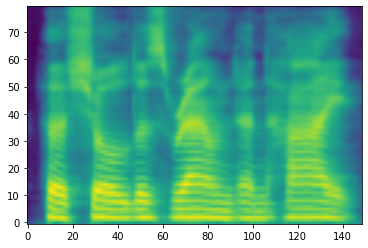

Real validation audio


SYNTHESIZED FOR -- Speaker: 6097 | Dataset size: 5 mins | Mixing:False | Text: how loudly they cry on the hook for the reaping of men doomed to die


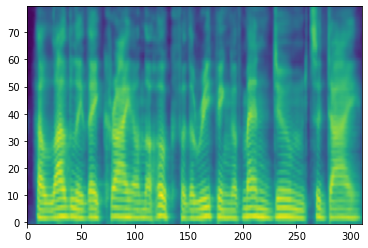

In [18]:
# Only need to set speaker_id if there is more than one speaker
speaker_id = None
if mixing:
    speaker_id = 1

num_val = 2  # Number of validation samples
val_records = []
with open(f"{new_speaker_id}_manifest_dev_ns_all_local.json", "r") as f:
    for i, line in enumerate(f):
        val_records.append(json.loads(line))
        if len(val_records) >= num_val:
            break
            
for val_record in val_records:
    print("Real validation audio")
    ipd.display(ipd.Audio(val_record['audio_filepath'], rate=22050))
    print(f"SYNTHESIZED FOR -- Speaker: {new_speaker_id} | Dataset size: {duration_mins} mins | Mixing:{mixing} | Text: {val_record['text']}")
    spec, audio = infer(spec_model, hifigan_model, val_record['text'], speaker=speaker_id)
    ipd.display(ipd.Audio(audio, rate=22050))
    %matplotlib inline
    imshow(spec, origin="lower", aspect="auto")
    plt.show()